# EDA and PREPROCESSING Notebook

**Notebook Structure**
* [Preprocessing](#Preprocessing)
* [Cleaning](#cleaning)
* [Stop Words](#stop_word)
* [EDA](#eda)
* [Count Vectorization](#cvec)
* [Frequency Vectorization](#fvec)
* [Top 25 Words Charts](#top25)
* [TFIDF Encoding](#tfidf)
* [Parts of Speech](#pos)
* [Parts of Speech Chart](#pos_chart)
* [Spacy Scattertext](#spacy)

# About This Notebook

This notebook takes in cleaned data that was pulled from r/Homebrewing and r/Winemaking subreddits, preprocesses it, executes and analyses exploratory data analysis and finishes off with a Spacy Scattertext plot. 

### Import Libraries

In [1100]:
#Standard Libraries
import pandas as pd
import numpy as np

# Importing Visualization Libraries
import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = 'black' # setting default background color
import seaborn as sns
import matplotlib.patches as mpatches

# NLP Libraries
from nltk import FreqDist, pos_tag
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
import re #regex
import contractions #contractions library 
import string

# Scikit Libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction import text
from sklearn.decomposition import PCA, TruncatedSVD

# Spacy Related Imports
import spacy
import scattertext as st
from scattertext import CorpusFromPandas, produce_scattertext_explorer

# imports related to deploying Spacy Scattertext within notebook and local browser.
import os, pkgutil, json, urllib
from urllib.request import urlopen
from IPython.display import IFrame
from IPython.core.display import display, HTML



**Notes on Special Import Libaries**
* os library info:
    https://docs.python.org/3/library/os.html
* pkgutil library info:
    https://docs.python.org/3/library/pkgutil.html
* urllib Library info:
    https://docs.python.org/3/library/urllib.html
* Ipython LIbrary (This looks like a cool one I will dive more into)
    https://ipython.org/

### Read in Data

In [1101]:
wine = pd.read_csv('../data/01_wine.csv', )
wine.head(1)

,title,selftext,subreddit
0,Resources for a newbie home winemaker,Resources for a newbie home winemaker I want t...,winemaking


In [1102]:
beer = pd.read_csv('../data/01_beer.csv')
beer.head(1)

,selftext,subreddit
0,Getting to the bottom of my keg and it is yeas...,Homebrewing


**Dropping title column** from both DFs. The text from the column has already been merged to selftext in the previous notebook. 

In [975]:
wine.drop(columns = 'title', inplace = True)
beer.drop(columns = 'title', inplace = True)

In [1088]:
print(wine.columns)
print(beer.columns)

Index(['title', 'selftext', 'subreddit'], dtype='object')
Index(['title', 'selftext', 'subreddit'], dtype='object')


# Concatenating 
wine and beer dataframes into one df on the row index 

In [979]:
posts_df = pd.concat([wine, beer], ignore_index = True)

In [981]:
posts_df.groupby('subreddit').count()

,selftext
subreddit,
Homebrewing,2367
winemaking,1935


<a id='Preprocessing'></a>__________________________________
# PREPROCESSING

<a id = 'cleaning'></a>
### Cleaning Symbols/Numbers/Capital Letters
* The code for this section has been adapted from this article in Towards Data Science and from class lecturs. 
* Articles contributions to this came in bits and pieces. I streamlined it into one function and added some other modifications. 
* This function takes in a df label and a series/column label, eliminates numbers, strips white space, lowercases characters, tokenizes the data, removes punctuations, sets changes to original series/column and keeps tokenized column. 
* https://towardsdatascience.com/preprocessing-text-data-using-python-576206753c28


In [983]:
def rmv_num_sym(df, series_label):
    
    # getting rid of numbers
    df[series_label] = df[series_label].str.replace('\d+', ' ')
    
    # stripping white space
    df[series_label]= df[series_label].str.strip(' ')
    
    # lowercase all remaining characters
    df[series_label] = df[series_label].str.lower()
   
    # removing punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    df[series_label] = df[series_label].apply(tokenizer.tokenize)
    
    # rejoining dataframe to no_contraction_str
    df[series_label] = [' '.join(map(str, l)) for l in df[series_label]]
    
    # make sure to reassign df to this function to set changes to permanent. 
    return df

In [984]:
posts_df  = rmv_num_sym(posts_df, 'selftext')

In [985]:
posts_df['selftext'][:20]

0     resources for a newbie home winemaker i want t...
1     a question about kit wine i ve made quite a fe...
2     riesling my first wine hi everyone i am going ...
3     persimmon wine straining hello this is my firs...
4     wire used for trellis hey all i m planting som...
5     when to kill the yeast when to bottle i have i...
6     noobie question about bottling this is probabl...
7     hours and no bubbles hi its my first time to m...
8     instant pot wine hey a poster in another sub r...
9     help my wine came out super dry and i m new to...
10    newbie here no rinse o wash hi all just got a ...
11    new to winemaking hey everyone i m sure this h...
12    is there a way to evaporate water from an ongo...
13    got a factory new ultramarine blue ferrari for...
14    winery vineyard owners what s the likely hood ...
15    how to add creamy taste to wine i m still plan...
16    years of aging cannot get rid of a sorbate mal...
17    where to get white merlot kits made some l

<a id= 'stop_word'></a>
## Stop Word Creation
inspired by these links:
* https://stackoverflow.com/questions/24386489/adding-words-to-scikit-learns-countvectorizers-stop-list
* https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe

* I combined this all into 1 function
* I decided to use both Count Vectorizer and NLTK stop words in addition to my own custom stop words found in EDA for the purpose of adding robustness. 

#### Creating Custom Stop Words

In [986]:
my_stop_words = ['just', 'like', 'make', 'add', 'know', 'use', 'does', 'good', 'did', 'https', 'com', 'time', 'want', 'got', 'used', 'use', 'really', 'using', 'little', 'think', 'imgur', 'imgur com', 'added', 'days', 'day', 'need', 'going', 'looking', 'new', '_', '__', '___', '____', ]

In [987]:
def stop_word_merger(custom_stops_list):
    
    # import string library
    import string
    
    # Merging Count Vectorizer Stop Words to Custom Stop Words
    # Union is used because cvec stops are a frozen set. 
    stop_words_custom = text.ENGLISH_STOP_WORDS.union(custom_stops_list)
    
    # converting NLTK stops from frozen set to list in order to add to custom stops
    nltk_stopwords = list(stopwords.words('english'))
    
    # again using union because stop_words_custom is a frozen set. 
    stop_words_custom = stop_words_custom.union(nltk_stopwords)
    
    stop_words_custom = stop_words_custom.union(list(string.ascii_lowercase))

    stop_words_custom - stop_words_custom.union(list(string.ascii_uppercase))
    
    # returning all three (cvec, nltk, custom) stop words lists as one list. 
    print(f'Length of Stop Words List: {len(stop_words_custom)}')
    
    return stop_words_custom
    

In [988]:
# calling stop_word_merger function with my custom stop words list
# and renaming it custom_stops for brevity
custom_stops = stop_word_merger(my_stop_words)

Length of Stop Words List: 425


In [989]:
# Printing all stop words. ## Remove colon to view ##
custom_stops;

#### Checking Amount of Stop Words

In [990]:
def stop_words_checker(df, series_label, stop_words):
    
    # Function that checks to see how many of stop words are in a series
    
    count = 0
    total_words = 0
    
    for posts in posts_df['selftext']:
        for word in posts.split():
            if word in stop_words:
                count += 1
    
    for posts in posts_df['selftext']:
        for word in posts.split():
            total_words += 1
       
    print(f'There are {count} stop words in this corpus.')
    print(f'Out of {total_words} total words in corpus.')
    print(f'Stop words account for {round((count / total_words * 100), ndigits = 2)}% of all words in corpus.')
    

In [991]:
stop_words_checker(posts_df, 'selftext', custom_stops)

There are 278247 stop words in this corpus.
Out of 471162 total words in corpus.
Stop words account for 59.06% of all words in corpus.


#### Removing Stop Words

In [992]:
def remove_stop_words(df, series_label, stop_words):
    
    # A function that removes stop words from corpus
    
    df['stop_out'] = df[series_label].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    df[series_label] = posts_df['stop_out']
    df.drop(columns = ['stop_out'], inplace = True)
    
    return df

In [993]:
# Relabeling posts_df to the Df cleaned of stopwords
posts_df = remove_stop_words(posts_df, 'selftext', custom_stops)

In [994]:
# checking to see if stop words are gone
stop_words_checker(posts_df, 'selftext', custom_stops)

There are 0 stop words in this corpus.
Out of 192915 total words in corpus.
Stop words account for 0.0% of all words in corpus.


____________________
<a id = 'eda'></a>
# EDA

## Creating seperate df's for homebrewing and winemaking

In [995]:
brew = posts_df[posts_df['subreddit'] == 'Homebrewing']
wine = posts_df[posts_df['subreddit'] == 'winemaking']

<a id='cvec'></a>
## Instantiating and Fitting CountVectorizers

Instantiating 2 seperate Count Vectorizers. One for Homebrewing DF and one for winemaking DF. I am doing this separately in order to analyze each df's word trends seperately.

**Instantiating Count Vectorizer for Brew and Wine DF's**

In [1061]:
cvec_brew = CountVectorizer(stop_words = custom_stops, 
                            ngram_range = (1,3))
cvec_wine = CountVectorizer(stop_words = custom_stops,  
                            ngram_range = (1,3))

**Fitting Brew and Wine Count Vectorizer**

In [1062]:
brew_vec = cvec_brew.fit_transform(brew['selftext'])
wine_vec = cvec_wine.fit_transform(wine['selftext'])

<a id='fvec'></a>
# Frequency Vectorization

## Top 25 Words in Homebrew and Winemaking Subreddits
* After stop words are removed
* After basic preprocessing with CountVectorizer

The code to achieve this was inspired by this site:
https://stackoverflow.com/questions/16078015/list-the-words-in-a-vocabulary-according-to-occurrence-in-a-text-corpus-with-sc

* I adapted the code to work in my custom function. 
* I can now easily do any amount of top words by adjusting n_words parameter. 

In [1000]:
def top_n_words(fitted_cnt_vect, count_vect, n_words):
    # Function takes a fitted count vectorizer, 
    # an instantiated count_vect and number of words
    # returns a DF of n number of top words and ngrams in descending order.
    
    sumd_vectors = fitted_cnt_vect.sum(axis = 0)
    
    word_freq = [(word, sumd_vectors[0, idx]) for word, idx in count_vect.vocabulary_.items()]
    
    top_words = sorted(word_freq, key = lambda x: x[1], reverse = True)[:n_words]
    
    top_words_df = pd.DataFrame(top_words)
    
    top_words_df.rename(columns = {0: 'word', 1: 'count'}, inplace = True)
    
    
    return top_words_df
    

**Top 25 Homebrewing Words**

In [1063]:
# creating top 25 homebrew DF by calling top_n_words function
beer_25_df = top_n_words(brew_vec, cvec_brew, 25)
beer_25_df.head()

,word,count
0,beer,1457
1,yeast,1137
2,brew,864
3,brewing,733
4,water,704


**Top 25 Winemaking Words**

In [1064]:
# creating top 25 homebrew DF by calling top_n_words function
wine_25_df = top_n_words(wine_vec, cvec_wine, 25)
wine_25_df.head()

,word,count
0,wine,3526
1,yeast,968
2,making,711
3,fermentation,649
4,sugar,532


<a id='top25'></a>
## Top 25 Word Charts

**Top 25 Words Homebrewing Chart**

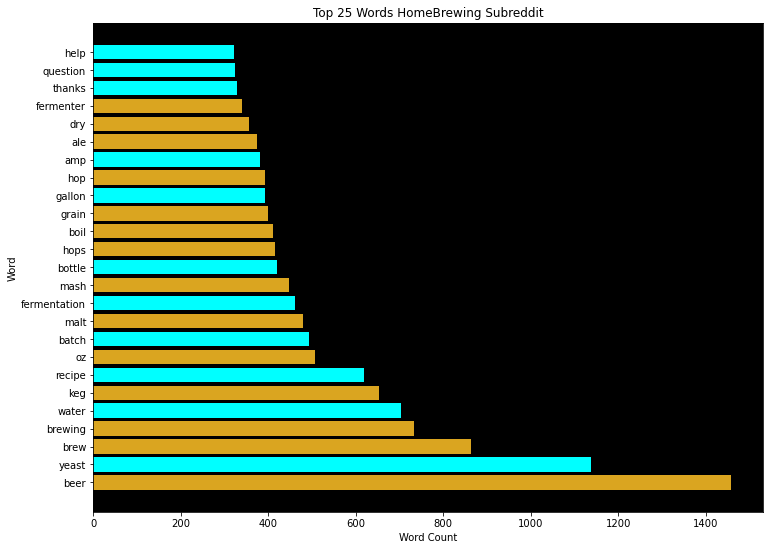

In [1065]:
brew_color_list = ['goldenrod', 'aqua', 'goldenrod', 'goldenrod', 
                   'aqua','goldenrod', 'aqua','goldenrod', 
                   'aqua','goldenrod', 'aqua','goldenrod', 
                   'aqua','goldenrod', 'goldenrod','goldenrod', 
                   'aqua','goldenrod', 'aqua','goldenrod', 
                   'goldenrod','goldenrod', 'aqua','aqua', 'aqua',]

x = list(beer_25_df['count'])
bars = list(beer_25_df['word'])
y_pos = np.arange(len(bars))
plt.figure(figsize = (12,9))
plt.barh(y_pos, x, color = brew_color_list)
plt.yticks(y_pos, bars, color = 'black')
plt.xticks(color = 'black')
plt.xlabel('Word Count', color = 'black')
plt.ylabel('Word', color = 'black')
plt.title('Top 25 Words HomeBrewing Subreddit', color = 'black')
plt.show()

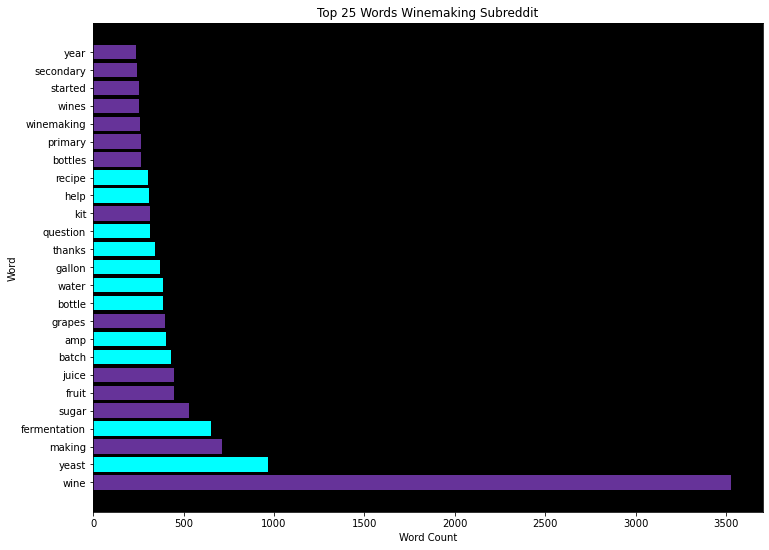

In [1004]:
wine_color_list = ['rebeccapurple', 'aqua', 'rebeccapurple', 'aqua', 
                   'rebeccapurple', 'rebeccapurple', 'rebeccapurple', 'aqua', 
                   'aqua', 'rebeccapurple', 'aqua', 'aqua', 
                   'aqua', 'aqua', 'aqua', 'rebeccapurple', 
                   'aqua', 'aqua', 'rebeccapurple', 'rebeccapurple', 
                   'rebeccapurple', 'rebeccapurple', 'rebeccapurple', 'rebeccapurple','rebeccapurple',]




x = list(wine_25_df['count'])
bars = list(wine_25_df['word'])
y_pos = np.arange(len(bars))

plt.figure(figsize = (12,9))
plt.barh(y_pos, x, color = wine_color_list)
plt.yticks(y_pos, bars, color = 'black')
plt.xticks(color = 'black')
plt.xlabel('Word Count', color = 'black')
plt.ylabel('Word', color = 'black')
plt.title('Top 25 Words Winemaking Subreddit', color = 'black')
plt.show()

In [1005]:
def shared_words(series_of_vect_words1, series_of_vect_words2):
    # A function that takes in two seperate series of different words
    # and returns a list of words shared between both series'
    
    shrd_wrds = []
    
    for word in series_of_vect_words1:
        for word2 in series_of_vect_words2:
            if word == word2:
                shrd_wrds.append(word)
                
    return shrd_wrds

In [1006]:
shared_words = shared_words(wine_25_df['word'], beer_25_df['word'])

In [1007]:
print(f' Words shared by both DFs: {shared_words}')

 Words shared by both DFs: ['yeast', 'fermentation', 'batch', 'amp', 'bottle', 'water', 'gallon', 'thanks', 'question', 'help', 'recipe']


### Analysis of Top 25 Word Charts

Not surprisingly the top word in Winemaking is 'wine' and the top word in Homebrewing is 'beer.' Also not surprising are other shared words in the top 25 such as fermentation, water and yeast. 

I think there are some distincive words in each of these lists that will make a prediciting model very successful. In the homebrewing list words like beer, brew, keg, hops and grain will add distinguishing capability to the model. In the winemaking list words like wine, grapes, primary and secondary will add distinguishing capability to the model.

### Outliers and Overly Frequent Words

After reviewing these charts it will likely be necessary to remove the terms 'wine', 'beer', 'brew' and 'brewing' from the corpus as these counts may make the model overpredictive to many of these features. 

In the case of words like 'yeast', 'fermentation', 'batch', 'amp', 'bottle', 'water', 'gallon', 'thanks', 'question', 'help' and 'recipe' it may be necessary to remove these words because they appear frequently in both models. 

[X] These words (All the mentioned words in this cell) are indeed removed later in the notebook. 
___________________________

<a id= 'tfidf'></a>
_________________________________
# TF-IDF Encoding
## IDF Values
The lower the IDF value of a word, the less unique it is to any particular document

Used this website for guidance on this process:
https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.X_DmeulKhTY

I used Tfidf Transformer instead of Tfidf Vectorizer.
Tf = term frequency
Tf-idf = term frequency times inverse document-frequency. This is a common term weighting scheme in information retrieval, that has also found good use in document classification. 

The goal of using tf-idf instead of the raw frequencies of occurence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus. 

Notes on TfidfTransformer Hyperparameters:
* smooth_idf was used (True is default), the constant 1 is added ot the numerator and denominator of the idf as if an extra document was seen continaing every term in collection exactly once, this prevents zero division. 
* use_idf (True is default), enables inverse-document-frequency reweighting. 

**Brew TF-IDF**

In [1008]:
tfidf_trans_brew = TfidfTransformer(smooth_idf = True, use_idf = True, sublinear_tf = True)
tfidf_trans_brew.fit(brew_vec)

TfidfTransformer(sublinear_tf=True)

**Wine TF-IDF**

In [1009]:
tfidf_trans_wine = TfidfTransformer(smooth_idf = True, use_idf = True, sublinear_tf = True)
tfidf_trans_wine.fit(wine_vec)

TfidfTransformer(sublinear_tf=True)

**Creating a DataFrame of IDF Values**

In [1010]:
idf_brew_df = pd.DataFrame(tfidf_trans_brew.idf_, 
                           index = cvec_brew.get_feature_names(), 
                           columns = ['idf_weights'])
idf_wine_df = pd.DataFrame(tfidf_trans_wine.idf_, 
                           index = cvec_wine.get_feature_names(), 
                           columns = ['idf_weights'])

In [1011]:
idf_brew_df.head(1)

,idf_weights
__________,8.076654


In [1091]:
idf_brew_df['idf_weights'].nsmallest(25)

beer            2.123410
yeast           2.427680
brew            2.434747
brewing         2.547225
recipe          2.845545
batch           2.864439
water           2.929159
thanks          2.985976
fermentation    3.001480
keg             3.072708
question        3.096478
help            3.186305
ale             3.205281
gallon          3.209119
way             3.209119
hops            3.212973
bottle          3.285004
grain           3.289162
brewed          3.310215
making          3.310215
malt            3.323064
mash            3.349266
fermenter       3.358155
sure            3.358155
thinking        3.367124
Name: idf_weights, dtype: float64

In [1093]:
idf_wine_df['idf_weights'].nsmallest(25)

wine            1.298763
making          2.254831
yeast           2.382171
fermentation    2.607374
thanks          2.736497
batch           2.778419
sugar           2.835038
question        2.966260
juice           2.969957
help            3.023202
fruit           3.058991
bottle          3.063048
gallon          3.075318
water           3.125962
grapes          3.183884
started         3.240503
winemaking      3.250259
wondering       3.255173
hi              3.270062
recipe          3.280112
way             3.321355
start           3.326632
primary         3.342633
advice          3.348023
try             3.358893
Name: idf_weights, dtype: float64

In [1014]:
idf_wine_df['subreddit'] = 'winemaking'
idf_wine_df.head(2)

,idf_weights,subreddit
_____,7.875232,winemaking
_____ gut,7.875232,winemaking


In [1015]:
idf_brew_df['subreddit'] = 'homebrewing'
idf_brew_df.head(2)

,idf_weights,subreddit
__________,8.076654,homebrewing
__________ amarillo,8.076654,homebrewing


**TF-IDF Dataframe with both Winemaking and Homebrewing**

In [1016]:
idf_df = pd.concat([idf_wine_df, idf_brew_df])
idf_df.tail(2)

,idf_weights,subreddit
⁰f bring,8.076654,homebrewing
⁰f bring warmer,8.076654,homebrewing


# Analysis TF-IDF 

The results here are not very surprising as the lowest weighted values are very similar to the top 25 most frequent words. I didn't include TF-IFD in any further steps because admittedly I didn't understand them very well when initially producing these results. In hindsight I think there is a possibility that TF-IDF may have some advantages as processed data. It is easy to calculate and would have saved me an extra step when I added more stop words because words appeared to frequently in both corpuses or had too much predictive capability. There are downsides to TF_IDF. It does not recognize the difference between plural and singular words and may incorrectly downplay the weightings of some words if they are represented by a good deal of both plural and singular nouns. 

"Although many new algorithms have come up in the recent past, the simple TF-IDF algorithm is still the benchmark for Query retrieval methods. But, the simple TF-IDF has its own limitations as well, like it fails to distinguish between a singular word and plural words. So, if suppose you search for ‘drug’, TF-IDF will not be able to equate the word ‘drug’ with ‘drugs’ categorizing each instead as separate words and slightly decreasing the word’s ‘Wd’ value."

* https://www.bluepiit.com/blog/using-tf-idf-algorithm-to-find-relevance-score-in-document-queries/#:~:text=%23%23%20Advantages%20of%20TF%2DIDF,relevant%20to%20a%20particular%20query


<a id = 'pos'></a>
# Parts of Speech Analysis using NLTK

**Create list of posts to be tokenized for each subreddit**

In [1017]:
brew_text = list(brew['selftext'])
wine_text = list(wine['selftext'])

In [1097]:
brew_text; ## remove semi-colon to view ##

**Tokenize using NLTK word tokenizer**

In [1019]:
brew_tokens = [word_tokenize(i) for i in brew_text]
wine_tokens = [word_tokenize(i) for i in wine_text]

In [1090]:
brew_tokens; ## Remove semi-colon to view ##

In [1082]:
#creating a list of words from wine subreddit to pos tag
wine_tag_list = []
for lst in wine_tokens:
    for item in lst:
        wine_tag_list.append(item)
        
# creating a list of words from wine subreddit to pos tag
brew_tag_list = []
for lst in brew_tokens:
    for item in lst:
        brew_tag_list.append(item)

**Executing Part-of-Speech tagging using Penn Treebank tags**

In [1023]:
wine_tag = pos_tag(wine_tag_list)
brew_tag = pos_tag(brew_tag_list)

**Creating DF's for Tagged Parts of Speech and their Words in Each Subreddit**

##### Wine Tags DF

In [1025]:
wine_tag_df = pd.DataFrame(wine_tag, columns = ['word', 'part_of_speech'])
wine_tag_df.head(1)

In [1078]:
total_words_wine = len(wine_tag_df)
print(f'total tagged words in Winemaking: {total_words_wine}')

total tagged words in Winemaking: 79886


##### Brew Tags DF

In [1028]:
brew_tag_df = pd.DataFrame(brew_tag, columns = ['word', 'part_of_speech'])
brew_tag_df.head(1)

In [1077]:
total_words_brew = len(brew_tag_df)
print(f'total tagged words in Homebrewing: {total_words_brew}')

total tagged words in Homebrewing: 113140


**Link to NLTK Tag Set**
https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

In [1031]:
wine_pos_values = wine_tag_df['part_of_speech'].value_counts()
wine_pos_values[:5]

NN     31537
JJ     16373
NNS     8736
VBG     5613
VBP     4040
Name: part_of_speech, dtype: int64

In [1032]:
brew_pos_values = brew_tag_df['part_of_speech'].value_counts()
brew_pos_values[:5]

NN     47272
JJ     22194
NNS    10896
VBG     6991
VBD     6637
Name: part_of_speech, dtype: int64

In [1033]:
brew_pos_value_df = pd.DataFrame(brew_pos_values)
brew_pos_value_df.head(1)

,part_of_speech
NN,47272


In [1034]:
wine_pos_value_df = pd.DataFrame(wine_pos_values)
wine_pos_value_df.head(1)

,part_of_speech
NN,31537


In [1035]:
brew_pos_value_df['pos_perc_of_words'] = brew_pos_value_df['part_of_speech'] / total_words_brew

In [1036]:
wine_pos_value_df['pos_perc_of_words'] = wine_pos_value_df['part_of_speech'] / total_words_wine

In [1098]:
brew_pos_value_df.head(2)

,part_of_speech,pos_perc_of_words
NN,47272,0.417819
JJ,22194,0.196164


In [1099]:
wine_pos_value_df.head(2)

,part_of_speech,pos_perc_of_words
NN,31537,0.394775
JJ,16373,0.204955


**Wine Parts of Speech Stats**

In [1039]:
wine_adjectives = (wine_pos_value_df['pos_perc_of_words']['JJ'] +
                   wine_pos_value_df['pos_perc_of_words']['JJR'] +
                   wine_pos_value_df['pos_perc_of_words']['JJS']) * 100
f'Wine Adjectives = {round(wine_adjectives, ndigits = 2)} Percent of Words'

'Wine Adjectives = 21.19 Percent of Words'

In [1040]:
wine_nouns = (wine_pos_value_df['pos_perc_of_words']['NN'] +
                   wine_pos_value_df['pos_perc_of_words']['NNS']) * 100
f'Wine Nouns = {round(wine_nouns, ndigits = 2)} Percent of Words'

'Wine Nouns = 50.41 Percent of Words'

In [1041]:
wine_adverbs = (wine_pos_value_df['pos_perc_of_words']['RB'] +
                   wine_pos_value_df['pos_perc_of_words']['RBR'] +
                   wine_pos_value_df['pos_perc_of_words']['RBS']) * 100
f'Wine Adverbs = {round(wine_adverbs, ndigits = 2)} Percent of Words'

'Wine Adverbs = 5.21 Percent of Words'

In [1042]:
wine_verbs = (wine_pos_value_df['pos_perc_of_words']['VB'] +
                   wine_pos_value_df['pos_perc_of_words']['VBD'] +
                   wine_pos_value_df['pos_perc_of_words']['VBG'] +
             wine_pos_value_df['pos_perc_of_words']['VBN'] +
                   wine_pos_value_df['pos_perc_of_words']['VBP'] +
                   wine_pos_value_df['pos_perc_of_words']['VBZ']) * 100
f'Wine Verbs = {round(wine_verbs, ndigits = 2)} Percent of Words'

'Wine Verbs = 22.07 Percent of Words'

**Brewing Parts of Speech Stats**

In [1043]:
brew_adjectives = (brew_pos_value_df['pos_perc_of_words']['JJ'] +
                   brew_pos_value_df['pos_perc_of_words']['JJR'] +
                   brew_pos_value_df['pos_perc_of_words']['JJS']) * 100
f'Brew Adjectives = {round(brew_adjectives, ndigits = 2)} Percent of Words'

'Brew Adjectives = 20.49 Percent of Words'

In [1044]:
brew_nouns = (brew_pos_value_df['pos_perc_of_words']['NN'] +
                   brew_pos_value_df['pos_perc_of_words']['NNS']) * 100
f'Brew Nouns = {round(brew_nouns, ndigits = 2)} Percent of Words'

'Brew Nouns = 51.41 Percent of Words'

In [1045]:
brew_adverbs = (brew_pos_value_df['pos_perc_of_words']['RB'] +
                   brew_pos_value_df['pos_perc_of_words']['RBR'] +
                   brew_pos_value_df['pos_perc_of_words']['RBS']) * 100
f'Brew Adverbs = {round(brew_adverbs, ndigits = 2)} Percent of Words'

'Brew Adverbs = 5.1 Percent of Words'

In [1046]:
brew_verbs = (brew_pos_value_df['pos_perc_of_words']['VB'] +
                   brew_pos_value_df['pos_perc_of_words']['VBD'] +
                   brew_pos_value_df['pos_perc_of_words']['VBG'] +
             brew_pos_value_df['pos_perc_of_words']['VBN'] +
                   brew_pos_value_df['pos_perc_of_words']['VBP'] +
                   brew_pos_value_df['pos_perc_of_words']['VBZ']) * 100
f'Brew Verbs = {round(brew_verbs, ndigits = 2)} Percent of Words'

'Brew Verbs = 21.55 Percent of Words'

<a id= 'pos_chart'></a>
### Parts of Speech Chart

In [1047]:
wine_pos_tags = [wine_adverbs, wine_adjectives, wine_verbs, wine_nouns]
brew_pos_tags = [brew_adverbs, brew_adjectives, brew_verbs, brew_nouns]

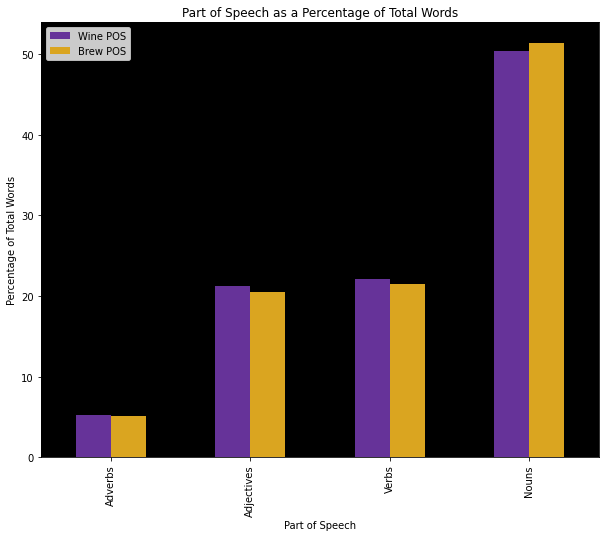

In [1048]:
compare_tags = pd.DataFrame({'Wine POS': wine_pos_tags, 
                            'Brew POS': brew_pos_tags})
compare_tags.plot.bar(figsize = (10, 8), 
                      color = ['rebeccapurple', 'goldenrod']).set_title('Part of Speech as a Percentage of Total Words')
plt.legend(facecolor = 'white')
plt.yticks(color = 'black')
plt.xticks(ticks = [0, 1, 2, 3], labels = ['Adverbs', 'Adjectives', 'Verbs', 'Nouns'], color = 'black')
plt.ylabel('Percentage of Total Words', color = 'black')
plt.xlabel('Part of Speech', color = 'black');

## Parts of Speech Chart Analysis

#### Nouns
* **NN means Noun, singular or mass.**
* **NNS is another form of Noun, plural.** 

Not surprising that it is the most common part of speech in both categories as nouns are a prominent part of all speech and especially when discussing tools used to produce things like wine and beer. 

#### Adjective
* **JJ mean Adjective**

another crucial part of every day language is found to be the 2nd most abundant part of speech used in both subreddits. 

#### Verbs
* **VBG means Verb gerund or present participle**
* **VBD means Verb, past tense**
* **VBP means Verb, 3rd person singular present.**

Verbs are also not suprisingly found amoung the most common words in both subredits. 

#### Final Thoughts of POS

I am disappointed that there are no glaring differences in POS of speech. However, what I do find interesting is the nearly identical numbers for both subreddits. The type of POS and the percentage of the respective POS in relation to total word count is almost identical in every category. This could be inspiration for further dives into POS research in groups that may not be so closely in common. It would be interesting to see if there can be some distinguishing characteristics. 

#### A Caveat

This POS analysis was done after stop words had been removed. This could have had an impact on the end results of the analysis. I think further research may also be necessary to compare POS before and after stop words are removed. If there is a difference it would be interesting to note if either subreddit used the stop words more or less than the other. This could have implications regarding command of language and perhaps culture of the different subreddits. 

## Finalizing Stop Words before Modeling

In [1049]:
shared_words.append('wine')
shared_words.append('beer')

In [1050]:
print(shared_words)

['yeast', 'fermentation', 'batch', 'amp', 'bottle', 'water', 'gallon', 'thanks', 'question', 'help', 'recipe', 'wine', 'beer']


**Removing Shared Words**

In [1051]:
stop_words_checker(posts_df, 'selftext', shared_words)

There are 15755 stop words in this corpus.
Out of 192915 total words in corpus.
Stop words account for 8.17% of all words in corpus.


In [1052]:
# removing my custom stop words with my custom function
posts_df = remove_stop_words(posts_df, 'selftext', shared_words)

In [1053]:
# checking on removed stop words from corpus. 
stop_words_checker(posts_df, 'selftext', shared_words)

There are 0 stop words in this corpus.
Out of 177160 total words in corpus.
Stop words account for 0.0% of all words in corpus.


# Saving Pre-Processed posts_df to csv

In [1054]:
posts_df.to_csv('../data/preprocessed_df.csv', index = False)

<a id='spacy'></a>
# Spacy Scattertext
* Code derived from Spacy Documentation and Jason Kessler's (Creator of Scattertext) personal Github. 

https://github.com/JasonKessler/scattertext/blob/master/demo_category_frequencies.py

A medium article from Jason Kessler regarding Scattertext. 
https://medium.com/analytics-vidhya/visualizing-phrase-prominence-and-category-association-with-scattertext-and-pytextrank-f7a5f036d4d2

video by Jason Kessler explaining Scattertext
https://www.youtube.com/watch?v=H7X9CA2pWKo

Slide share presentation from Jason Kessler
https://www.slideshare.net/JasonKessler/natural-language-visualization-with-scattertext

*Scattertext documentation that only has half the code needed to deploy the model. :(
https://spacy.io/universe/project/scattertext

* Disclosure, I recieved advice from my brother, who works in data sciene, on how to employ this plot in an html file on my web browser. 


In [1057]:
# Instantiating spacy nlp object
nlp = spacy.load('en')

In [1058]:
# Creating Tokenized Text by applying nlp object
posts_df['tokenized'] = posts_df['selftext'].apply(nlp)

In [1059]:
# This function creates a pandas df from a corpus. 
# The nlp object must be applied to the corpus first. 

corpus = st.CorpusFromPandas(posts_df,
                             category_col='subreddit',
                             text_col='selftext',
                             nlp=nlp).build()


In [1060]:
# This function calls the plot
html = produce_scattertext_explorer(corpus, 
                            category = 'winemaking',
                            category_name = 'Winemaking',
                            not_category_name = 'Homebrewing', 
                            width_in_pixels=1200, 
                            show_characteristic = False,
                            minimum_term_frequency = 5, )
file = '../data/02_scattertext.html'
open(file, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1400, height=1000)